# Install Library

In [ ]:
%%capture
%%time
!pip install tqdm
!pip install sastrawi
!pip install swifter
!pip install wordcloud

# Import Library

In [ ]:
# from google.colab import drive
import pandas as pd
import re
import string
from tqdm import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# detokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data

Dataset ini berisi tweet yang di-scrap dengan kata kunci 'pendidikan indonesia' mulai tanggal 1 Januari 2024 hingga 21 Juni 2024. Tweet tersebut berbahasa Indonesia (lang: id) dan menangkap wacana publik tentang topik pendidikan di Indonesia pada periode tersebut.

In [ ]:
# drive.mount('/content/drive/', force_remount=True)
raw_dataset = pd.read_csv("/content/scrapped_pendindo.csv")

raw_dataset

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.798300e+18,Wed Jun 05 10:32:58 +0000 2024,36,Isu UKT udah tenggelam bukan berarti masalahny...,1.798300e+18,https://pbs.twimg.com/media/GPTaHslXQAEs1NW.jpg,NaN,in,"Utrecht, The Netherlands",3,0,17,https://x.com/ali_abdillah_/status/17983019829...,1.124468e+08,ali_abdillah_
1,1.798210e+18,Wed Jun 05 04:38:32 +0000 2024,1,kata dia setiap orang itu punya kepintaran dan...,1.798210e+18,NaN,danialnoer,in,safe space,0,0,0,https://x.com/danialnoer/status/17982127882902...,3.301452e+09,danialnoer
2,1.798150e+18,Wed Jun 05 00:12:55 +0000 2024,0,sampe muncullah video that man (iya video pak ...,1.798150e+18,NaN,akupastibina,in,"Surabaya, Indonesia",0,1,0,https://x.com/akupastibina/status/179814594136...,1.682590e+18,akupastibina
3,1.798000e+18,Tue Jun 04 14:32:41 +0000 2024,0,Habis tapera ntar terbit tapenna tabungan pend...,1.798000e+18,NaN,NaN,in,almost home,0,0,0,https://x.com/ahn_nanta/status/179799992182157...,4.005637e+08,ahn_nanta
4,1.797770e+18,Tue Jun 04 05:04:39 +0000 2024,0,@wortel1907 @tanyakanrl gini kn sekarang ada k...,1.797860e+18,NaN,wortel1907,in,"Jakarta Pusat, DKI Jakarta",0,0,0,https://x.com/kleerien/status/1797856973272265187,1.566710e+18,kleerien
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1.746890e+18,Mon Jan 15 16:36:05 +0000 2024,0,@ardisatriawan kondisi PTNBH hari ini terutama...,1.746930e+18,NaN,ardisatriawan,in,Constantinople,0,0,0,https://x.com/qwdwqjbdwk/status/17469342878221...,1.274780e+18,qwdwqjbdwk
480,1.746400e+18,Sun Jan 14 05:25:58 +0000 2024,1,jastip jasa titip bayar ukt uang kuliah tungga...,1.746400e+18,https://pbs.twimg.com/media/GDx4gTObQAAHLuX.jpg,NaN,in,"testi, wa, dm →",1,0,0,https://x.com/keciyI/status/1746403260918014337,1.471990e+18,keciyI
481,1.744950e+18,Wed Jan 10 04:54:09 +0000 2024,0,Juga berani buat lawan eropa perihal CPO dan b...,1.744950e+18,NaN,liliisflower,in,NaN,0,1,0,https://x.com/liliisflower/status/174494570054...,1.279340e+18,liliisflower
482,1.743840e+18,Sun Jan 07 03:34:43 +0000 2024,0,Sebelumnya dalam setiap doa untuk anak saya na...,1.743840e+18,NaN,ulilibun,in,Japan,0,1,0,https://x.com/ulilibun/status/1743838549752062172,8.495658e+07,ulilibun


1.	conversation_id_str: Unique identifier for the conversation thread to which the tweet belongs.
2.	created_at: Timestamp indicating when the tweet was created.
3.	favorite_count: The number of likes the tweet received.
4.	full_text: The full text content of the tweet.
5.	id_str: Unique identifier for the tweet.
6.	image_url: URL of any image attached to the tweet (if applicable).
7.	in_reply_to_screen_name: Username of the user to whom the tweet is replying (if applicable).
8.	lang: Language of the tweet, should be 'id' indicating Indonesian.
9.	location: Location information of the tweet, if available.
10.	quote_count: The number of times the tweet was quoted.
11.	reply_count: The number of replies the tweet received.
12.	retweet_count: The number of times the tweet was retweeted.
13.	tweet_url: URL link to the tweet.
14.	user_id_str: Unique identifier for the user who posted the tweet.
15.	username: Username of the user who posted the tweet.


# Preprocessing

## Data Cleaning

In [ ]:
#CHECKING MISSING VALUES
raw_dataset.isnull().sum()

,0
conversation_id_str,0
created_at,0
favorite_count,0
full_text,0
id_str,0
image_url,389
in_reply_to_screen_name,291
lang,0
location,197
quote_count,0


In [ ]:
# Preprocessing data
def cleaning_text(text):
    # Hapus tagging username
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'#\S+', ' ', text)

    # hapus emoji
    regrex_pattern = re.compile(pattern = "["
      u"\U00002700-\U000027BF"  # Dingbats
      u"\U0001F600-\U0001F64F"  # Emoticons
      u"\U00002600-\U000026FF"  # Miscellaneous Symbols
      u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
      u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
      u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
      u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
      "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r' ',text)

    # Hapus tanda baca, angka, dan karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\\x\S+', ' ', text)
    text = re.sub(r'\\u\S+', ' ', text)

    for sp in string.punctuation:
      text = text.replace(sp, " ")
    text = re.sub(r"\d+","",text)
    text = text.replace('/\s\s+/g', ' ')

    # Hapus kata RT
    text = re.sub(r'\bRT\b', ' ', text)
    # Hapus URL
    text = re.sub(r'((www.\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub(r'http\S+', ' ', text)

    # Hapus text yang menggabungkan karakter yang sama yang berulang berturut-turut dalam suatu teks
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'\\n', ' ', text)

    # Hapus whitespace berlebih
    text = text.strip()
    text = re.sub('\s+', ' ', text)

    return text

# Lakukan preprocessing pada kolom 'text'
tqdm.pandas(desc="Processing Cleaning Text: ")
raw_dataset['clean'] = raw_dataset['full_text'].apply(cleaning_text)

raw_dataset

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,clean
0,1.798300e+18,Wed Jun 05 10:32:58 +0000 2024,36,Isu UKT udah tenggelam bukan berarti masalahny...,1.798300e+18,https://pbs.twimg.com/media/GPTaHslXQAEs1NW.jpg,NaN,in,"Utrecht, The Netherlands",3,0,17,https://x.com/ali_abdillah_/status/17983019829...,1.124468e+08,ali_abdillah_,Isu UKT udah tenggelam bukan berarti masalahny...
1,1.798210e+18,Wed Jun 05 04:38:32 +0000 2024,1,kata dia setiap orang itu punya kepintaran dan...,1.798210e+18,NaN,danialnoer,in,safe space,0,0,0,https://x.com/danialnoer/status/17982127882902...,3.301452e+09,danialnoer,kata dia setiap orang itu punya kepintaran dan...
2,1.798150e+18,Wed Jun 05 00:12:55 +0000 2024,0,sampe muncullah video that man (iya video pak ...,1.798150e+18,NaN,akupastibina,in,"Surabaya, Indonesia",0,1,0,https://x.com/akupastibina/status/179814594136...,1.682590e+18,akupastibina,sampe muncullah video that man iya video pak a...
3,1.798000e+18,Tue Jun 04 14:32:41 +0000 2024,0,Habis tapera ntar terbit tapenna tabungan pend...,1.798000e+18,NaN,NaN,in,almost home,0,0,0,https://x.com/ahn_nanta/status/179799992182157...,4.005637e+08,ahn_nanta,Habis tapera ntar terbit tapenna tabungan pend...
4,1.797770e+18,Tue Jun 04 05:04:39 +0000 2024,0,@wortel1907 @tanyakanrl gini kn sekarang ada k...,1.797860e+18,NaN,wortel1907,in,"Jakarta Pusat, DKI Jakarta",0,0,0,https://x.com/kleerien/status/1797856973272265187,1.566710e+18,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1.746890e+18,Mon Jan 15 16:36:05 +0000 2024,0,@ardisatriawan kondisi PTNBH hari ini terutama...,1.746930e+18,NaN,ardisatriawan,in,Constantinople,0,0,0,https://x.com/qwdwqjbdwk/status/17469342878221...,1.274780e+18,qwdwqjbdwk,kondisi PTNBH hari ini terutama kampus saya yg...
480,1.746400e+18,Sun Jan 14 05:25:58 +0000 2024,1,jastip jasa titip bayar ukt uang kuliah tungga...,1.746400e+18,https://pbs.twimg.com/media/GDx4gTObQAAHLuX.jpg,NaN,in,"testi, wa, dm →",1,0,0,https://x.com/keciyI/status/1746403260918014337,1.471990e+18,keciyI,jastip jasa titip bayar ukt uang kuliah tungga...
481,1.744950e+18,Wed Jan 10 04:54:09 +0000 2024,0,Juga berani buat lawan eropa perihal CPO dan b...,1.744950e+18,NaN,liliisflower,in,NaN,0,1,0,https://x.com/liliisflower/status/174494570054...,1.279340e+18,liliisflower,Juga berani buat lawan eropa perihal CPO dan b...
482,1.743840e+18,Sun Jan 07 03:34:43 +0000 2024,0,Sebelumnya dalam setiap doa untuk anak saya na...,1.743840e+18,NaN,ulilibun,in,Japan,0,1,0,https://x.com/ulilibun/status/1743838549752062172,8.495658e+07,ulilibun,Sebelumnya dalam setiap doa untuk anak saya na...


Drop kolom tidak digunakan

In [ ]:
dataset_baru = raw_dataset[['username', 'clean']]
dataset_baru = raw_dataset[['username', 'clean']]
dataset_baru.head()


,username,clean
0,ali_abdillah_,Isu UKT udah tenggelam bukan berarti masalahny...
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...
2,akupastibina,sampe muncullah video that man iya video pak a...
3,ahn_nanta,Habis tapera ntar terbit tapenna tabungan pend...
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...


In [ ]:
dataset_baru['clean'][200]

'Hidup di negara merdeka tapi sejatinya dijajah terhimpit serba sulit Buya Anwar Abbas ini salah satu ketua Majelis Ulama Indonesia MUI Mahasiswa terhimpit UKT yang melejit Anwar Abbas Pendidikan hanya untuk yang kaya t co OqGbsoq'

## Case Folding

In [ ]:
# Uppercase to lowercase
def case_folding_text(text):
  return str(text).lower()

tqdm.pandas(desc="Processing Case Folding: ")
dataset_baru['clean'] = dataset_baru['clean'].progress_apply(case_folding_text)
dataset_baru.head()

Processing Case Folding: 100%|██████████| 484/484 [00:00<00:00, 66473.79it/s]
<ipython-input-11-17bff0ed8c7a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['clean'] = dataset_baru['clean'].progress_apply(case_folding_text)


,username,clean
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...
2,akupastibina,sampe muncullah video that man iya video pak a...
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...


## Tokenization

In [ ]:
def tokenizing_text(data):
    return nltk.tokenize.word_tokenize(data)

tqdm.pandas(desc="Processing tokenize: ")
dataset_baru['tokens'] = dataset_baru['clean'].progress_apply(tokenizing_text)
dataset_baru.head()

Processing tokenize: 100%|██████████| 484/484 [00:00<00:00, 4583.79it/s]
<ipython-input-12-f54a389b0894>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['tokens'] = dataset_baru['clean'].progress_apply(tokenizing_text)


,username,clean,tokens
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma..."
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta..."
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide..."
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga..."
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik..."


## Normalisasi

In [ ]:
dict_normalisasi = pd.read_csv('/content/kamus_alay.csv')
dict_normalisasi

,slang,normal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
...,...,...
18635,mendikbud,menteri pendidikan dan kebudayaan
18636,mendag,menteri perdagangan
18637,menaker,menteri tenaga kerja
18638,memetwit,mentwit


In [ ]:
dict_norm = dict(dict_normalisasi.values)

def normalized_term(document):
    filtered_document = document.copy()
    for idx, term in enumerate(filtered_document):
      if term in dict_norm:
          filtered_document[idx] = dict_norm[term]
    return filtered_document

tqdm.pandas(desc="Processing Normalisasi: ")
dataset_baru['tokens_normalized'] = dataset_baru['tokens'].progress_apply(normalized_term)
dataset_baru

Processing Normalisasi: 100%|██████████| 484/484 [00:00<00:00, 104190.27it/s]
<ipython-input-15-63785f75258c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['tokens_normalized'] = dataset_baru['tokens'].progress_apply(normalized_term)


,username,clean,tokens,tokens_normalized
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma...","[isu, ukt, sudah, tenggelam, bukan, berarti, m..."
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta...","[kata, dia, setiap, orang, itu, punya, kepinta..."
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide...","[sampai, muncullah, video, that, man, iya, vid..."
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga...","[habis, tapera, nanti, terbit, tapenna, tabung..."
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik...","[begini, kan, sekarang, ada, kebijakan, ukt, n..."
...,...,...,...,...
479,qwdwqjbdwk,kondisi ptnbh hari ini terutama kampus saya yg...,"[kondisi, ptnbh, hari, ini, terutama, kampus, ...","[kondisi, ptnbh, hari, ini, terutama, kampus, ..."
480,keciyI,jastip jasa titip bayar ukt uang kuliah tungga...,"[jastip, jasa, titip, bayar, ukt, uang, kuliah...","[jastip, jasa, titip, bayar, ukt, uang, kuliah..."
481,liliisflower,juga berani buat lawan eropa perihal cpo dan b...,"[juga, berani, buat, lawan, eropa, perihal, cp...","[juga, berani, buat, lawan, eropa, perihal, cp..."
482,ulilibun,sebelumnya dalam setiap doa untuk anak saya na...,"[sebelumnya, dalam, setiap, doa, untuk, anak, ...","[sebelumnya, dalam, setiap, doa, untuk, anak, ..."


## Stopword

In [ ]:
# Preprocessing data
def stopword_text(tokens):
    stopword = stopwords.words('indonesian')
    filtered_tokens = [token for token in tokens if token not in stopword]
    return filtered_tokens

tqdm.pandas(desc="Processing Stopword: ")
dataset_baru['tokens_normalized_stopwords'] = dataset_baru['tokens_normalized'].progress_apply(stopword_text)

dataset_baru.head()

Processing Stopword: 100%|██████████| 484/484 [00:00<00:00, 1584.59it/s]
<ipython-input-16-5e418e8c7df9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['tokens_normalized_stopwords'] = dataset_baru['tokens_normalized'].progress_apply(stopword_text)


,username,clean,tokens,tokens_normalized,tokens_normalized_stopwords
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma...","[isu, ukt, sudah, tenggelam, bukan, berarti, m...","[isu, ukt, tenggelam, selesai, bom, permasalah..."
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta...","[kata, dia, setiap, orang, itu, punya, kepinta...","[orang, kepintaran, bakatnya, siswa, tau, tuju..."
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide...","[sampai, muncullah, video, that, man, iya, vid...","[muncullah, video, that, man, iya, video, anie..."
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga...","[habis, tapera, nanti, terbit, tapenna, tabung...","[habis, tapera, terbit, tapenna, tabungan, pen..."
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik...","[begini, kan, sekarang, ada, kebijakan, ukt, n...","[kebijakan, ukt, bangsa, indonesia, dibawa, ke..."


## Stemming

In [ ]:
# Preprocessing data
def stemming_text(tokens):
    # Stemming teks dengan Sastrawi
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stems = [stemmer.stem(token) for token in tokens]
    return stems

tqdm.pandas(desc="Processing Stemming: ")
dataset_baru['tokens_normalized_stopwords_stemmed'] = dataset_baru['tokens_normalized_stopwords'].progress_apply(stemming_text)

dataset_baru.head()

Processing Stemming: 100%|██████████| 484/484 [05:04<00:00,  1.59it/s]
<ipython-input-17-7248cb343eb3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['tokens_normalized_stopwords_stemmed'] = dataset_baru['tokens_normalized_stopwords'].progress_apply(stemming_text)


,username,clean,tokens,tokens_normalized,tokens_normalized_stopwords,tokens_normalized_stopwords_stemmed
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma...","[isu, ukt, sudah, tenggelam, bukan, berarti, m...","[isu, ukt, tenggelam, selesai, bom, permasalah...","[isu, ukt, tenggelam, selesai, bom, masalah, d..."
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta...","[kata, dia, setiap, orang, itu, punya, kepinta...","[orang, kepintaran, bakatnya, siswa, tau, tuju...","[orang, pintar, bakat, siswa, tau, tuju, kulia..."
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide...","[sampai, muncullah, video, that, man, iya, vid...","[muncullah, video, that, man, iya, video, anie...","[muncul, video, that, man, iya, video, anies, ..."
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga...","[habis, tapera, nanti, terbit, tapenna, tabung...","[habis, tapera, terbit, tapenna, tabungan, pen...","[habis, tapera, terbit, tapenna, tabung, didik..."
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik...","[begini, kan, sekarang, ada, kebijakan, ukt, n...","[kebijakan, ukt, bangsa, indonesia, dibawa, ke...","[bijak, ukt, bangsa, indonesia, bawa, mana, or..."


In [ ]:
dataset_baru

,username,clean,tokens,tokens_normalized,tokens_normalized_stopwords,tokens_normalized_stopwords_stemmed
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma...","[isu, ukt, sudah, tenggelam, bukan, berarti, m...","[isu, ukt, tenggelam, selesai, bom, permasalah...","[isu, ukt, tenggelam, selesai, bom, masalah, d..."
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta...","[kata, dia, setiap, orang, itu, punya, kepinta...","[orang, kepintaran, bakatnya, siswa, tau, tuju...","[orang, pintar, bakat, siswa, tau, tuju, kulia..."
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide...","[sampai, muncullah, video, that, man, iya, vid...","[muncullah, video, that, man, iya, video, anie...","[muncul, video, that, man, iya, video, anies, ..."
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga...","[habis, tapera, nanti, terbit, tapenna, tabung...","[habis, tapera, terbit, tapenna, tabungan, pen...","[habis, tapera, terbit, tapenna, tabung, didik..."
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik...","[begini, kan, sekarang, ada, kebijakan, ukt, n...","[kebijakan, ukt, bangsa, indonesia, dibawa, ke...","[bijak, ukt, bangsa, indonesia, bawa, mana, or..."
...,...,...,...,...,...,...
479,qwdwqjbdwk,kondisi ptnbh hari ini terutama kampus saya yg...,"[kondisi, ptnbh, hari, ini, terutama, kampus, ...","[kondisi, ptnbh, hari, ini, terutama, kampus, ...","[kondisi, ptnbh, kampus, kemarin, ramai, sebut...","[kondisi, ptnbh, kampus, kemarin, ramai, sebut..."
480,keciyI,jastip jasa titip bayar ukt uang kuliah tungga...,"[jastip, jasa, titip, bayar, ukt, uang, kuliah...","[jastip, jasa, titip, bayar, ukt, uang, kuliah...","[jastip, jasa, titip, bayar, ukt, uang, kuliah...","[jastip, jasa, titip, bayar, ukt, uang, kuliah..."
481,liliisflower,juga berani buat lawan eropa perihal cpo dan b...,"[juga, berani, buat, lawan, eropa, perihal, cp...","[juga, berani, buat, lawan, eropa, perihal, cp...","[berani, lawan, eropa, perihal, cpo, bijih, ni...","[berani, lawan, eropa, perihal, cpo, bijih, ni..."
482,ulilibun,sebelumnya dalam setiap doa untuk anak saya na...,"[sebelumnya, dalam, setiap, doa, untuk, anak, ...","[sebelumnya, dalam, setiap, doa, untuk, anak, ...","[doa, anak, nazarkan, tabungan, pendidikan, ku...","[doa, anak, nazar, tabung, didik, kuliah, salu..."


## Detokenize

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detokenize(tokens):
  return TreebankWordDetokenizer().detokenize(tokens)

tqdm.pandas(desc="Processing De-tokenize: ")
dataset_baru['detokenize'] = dataset_baru['tokens_normalized_stopwords_stemmed'].progress_apply(detokenize)
dataset_baru.head()

Processing De-tokenize: 100%|██████████| 484/484 [00:00<00:00, 3850.31it/s]
<ipython-input-19-f1dd7f76520b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_baru['detokenize'] = dataset_baru['tokens_normalized_stopwords_stemmed'].progress_apply(detokenize)


,username,clean,tokens,tokens_normalized,tokens_normalized_stopwords,tokens_normalized_stopwords_stemmed,detokenize
0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"[isu, ukt, udah, tenggelam, bukan, berarti, ma...","[isu, ukt, sudah, tenggelam, bukan, berarti, m...","[isu, ukt, tenggelam, selesai, bom, permasalah...","[isu, ukt, tenggelam, selesai, bom, masalah, d...",isu ukt tenggelam selesai bom masalah didik in...
1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"[kata, dia, setiap, orang, itu, punya, kepinta...","[kata, dia, setiap, orang, itu, punya, kepinta...","[orang, kepintaran, bakatnya, siswa, tau, tuju...","[orang, pintar, bakat, siswa, tau, tuju, kulia...",orang pintar bakat siswa tau tuju kuliah bicar...
2,akupastibina,sampe muncullah video that man iya video pak a...,"[sampe, muncullah, video, that, man, iya, vide...","[sampai, muncullah, video, that, man, iya, vid...","[muncullah, video, that, man, iya, video, anie...","[muncul, video, that, man, iya, video, anies, ...",muncul video that man iya video anies wkwk waw...
3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"[habis, tapera, ntar, terbit, tapenna, tabunga...","[habis, tapera, nanti, terbit, tapenna, tabung...","[habis, tapera, terbit, tapenna, tabungan, pen...","[habis, tapera, terbit, tapenna, tabung, didik...",habis tapera terbit tapenna tabung didik anak ...
4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"[gini, kn, sekarang, ada, kebijakan, ukt, naik...","[begini, kan, sekarang, ada, kebijakan, ukt, n...","[kebijakan, ukt, bangsa, indonesia, dibawa, ke...","[bijak, ukt, bangsa, indonesia, bawa, mana, or...",bijak ukt bangsa indonesia bawa mana orang but...


In [ ]:
dataset_baru.to_csv('/content/pendindoAfter_preprocesing.csv')

# ***Gunakan dataset baru setelah preprocesing***


In [ ]:
df = pd.read_csv("/content/pendindoAfter_preprocesing.csv")

df

,Unnamed: 0,username,clean,tokens,tokens_normalized,tokens_normalized_stopwords,tokens_normalized_stopwords_stemmed,detokenize
0,0,ali_abdillah_,isu ukt udah tenggelam bukan berarti masalahny...,"['isu', 'ukt', 'udah', 'tenggelam', 'bukan', '...","['isu', 'ukt', 'sudah', 'tenggelam', 'bukan', ...","['isu', 'ukt', 'tenggelam', 'selesai', 'bom', ...","['isu', 'ukt', 'tenggelam', 'selesai', 'bom', ...",isu ukt tenggelam selesai bom masalah didik in...
1,1,danialnoer,kata dia setiap orang itu punya kepintaran dan...,"['kata', 'dia', 'setiap', 'orang', 'itu', 'pun...","['kata', 'dia', 'setiap', 'orang', 'itu', 'pun...","['orang', 'kepintaran', 'bakatnya', 'siswa', '...","['orang', 'pintar', 'bakat', 'siswa', 'tau', '...",orang pintar bakat siswa tau tuju kuliah bicar...
2,2,akupastibina,sampe muncullah video that man iya video pak a...,"['sampe', 'muncullah', 'video', 'that', 'man',...","['sampai', 'muncullah', 'video', 'that', 'man'...","['muncullah', 'video', 'that', 'man', 'iya', '...","['muncul', 'video', 'that', 'man', 'iya', 'vid...",muncul video that man iya video anies wkwk waw...
3,3,ahn_nanta,habis tapera ntar terbit tapenna tabungan pend...,"['habis', 'tapera', 'ntar', 'terbit', 'tapenna...","['habis', 'tapera', 'nanti', 'terbit', 'tapenn...","['habis', 'tapera', 'terbit', 'tapenna', 'tabu...","['habis', 'tapera', 'terbit', 'tapenna', 'tabu...",habis tapera terbit tapenna tabung didik anak ...
4,4,kleerien,gini kn sekarang ada kebijakan ukt naik bangsa...,"['gini', 'kn', 'sekarang', 'ada', 'kebijakan',...","['begini', 'kan', 'sekarang', 'ada', 'kebijaka...","['kebijakan', 'ukt', 'bangsa', 'indonesia', 'd...","['bijak', 'ukt', 'bangsa', 'indonesia', 'bawa'...",bijak ukt bangsa indonesia bawa mana orang but...
...,...,...,...,...,...,...,...,...
479,479,qwdwqjbdwk,kondisi ptnbh hari ini terutama kampus saya yg...,"['kondisi', 'ptnbh', 'hari', 'ini', 'terutama'...","['kondisi', 'ptnbh', 'hari', 'ini', 'terutama'...","['kondisi', 'ptnbh', 'kampus', 'kemarin', 'ram...","['kondisi', 'ptnbh', 'kampus', 'kemarin', 'ram...",kondisi ptnbh kampus kemarin ramai sebut ukt n...
480,480,keciyI,jastip jasa titip bayar ukt uang kuliah tungga...,"['jastip', 'jasa', 'titip', 'bayar', 'ukt', 'u...","['jastip', 'jasa', 'titip', 'bayar', 'ukt', 'u...","['jastip', 'jasa', 'titip', 'bayar', 'ukt', 'u...","['jastip', 'jasa', 'titip', 'bayar', 'ukt', 'u...",jastip jasa titip bayar ukt uang kuliah tungga...
481,481,liliisflower,juga berani buat lawan eropa perihal cpo dan b...,"['juga', 'berani', 'buat', 'lawan', 'eropa', '...","['juga', 'berani', 'buat', 'lawan', 'eropa', '...","['berani', 'lawan', 'eropa', 'perihal', 'cpo',...","['berani', 'lawan', 'eropa', 'perihal', 'cpo',...",berani lawan eropa perihal cpo bijih nikel ind...
482,482,ulilibun,sebelumnya dalam setiap doa untuk anak saya na...,"['sebelumnya', 'dalam', 'setiap', 'doa', 'untu...","['sebelumnya', 'dalam', 'setiap', 'doa', 'untu...","['doa', 'anak', 'nazarkan', 'tabungan', 'pendi...","['doa', 'anak', 'nazar', 'tabung', 'didik', 'k...",doa anak nazar tabung didik kuliah salur mahas...


# **Definisi WordCloud**

Wordcloud adalah representasi visual dari kumpulan kata dalam bentuk awan, di mana ukuran setiap kata menunjukkan frekuensi atau tingkat kepentingannya dalam teks yang dianalisis. Kata-kata yang sering muncul akan ditampilkan dengan ukuran lebih besar, sementara kata-kata yang jarang muncul akan ditampilkan lebih kecil. Wordcloud biasanya digunakan untuk mendapatkan gambaran cepat mengenai topik atau tema yang dominan dalam sebuah teks, seperti artikel, media sosial, atau kumpulan dokumen lainnya, dan sangat membantu dalam analisis teks secara visual.

# **WordCloud Sebelum Pre-Procesing**

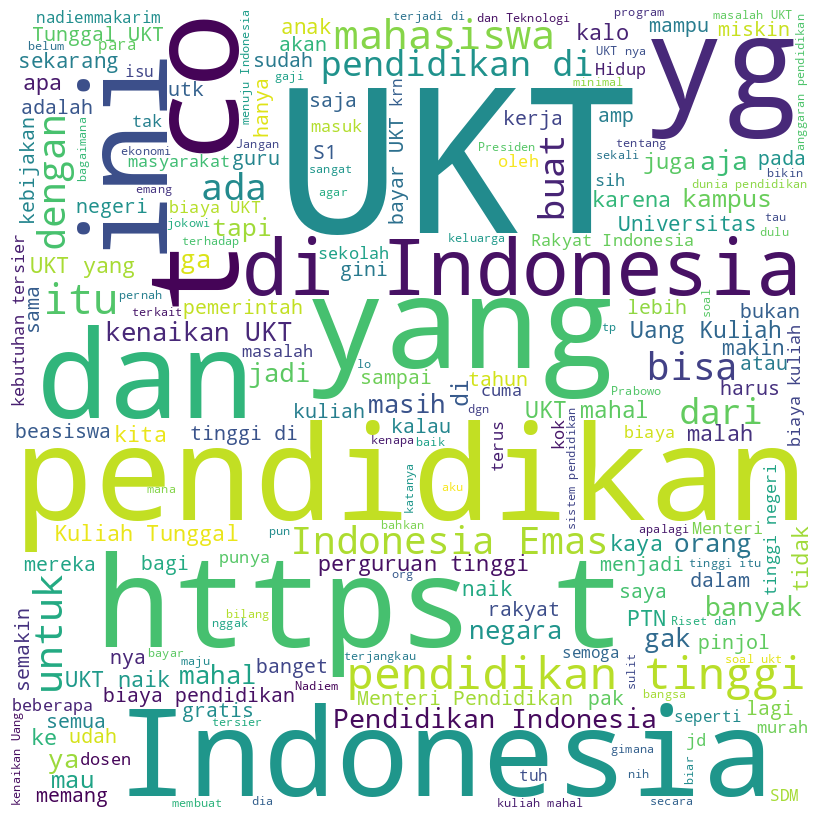

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Gabungkan semua teks dari kolom 'detokenize' menjadi satu string
all_text = ' '.join(raw_dataset['full_text'].astype(str).tolist())

# Buat objek WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(all_text)

# Tampilkan wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# **WordCloud setelah pre-procesing**

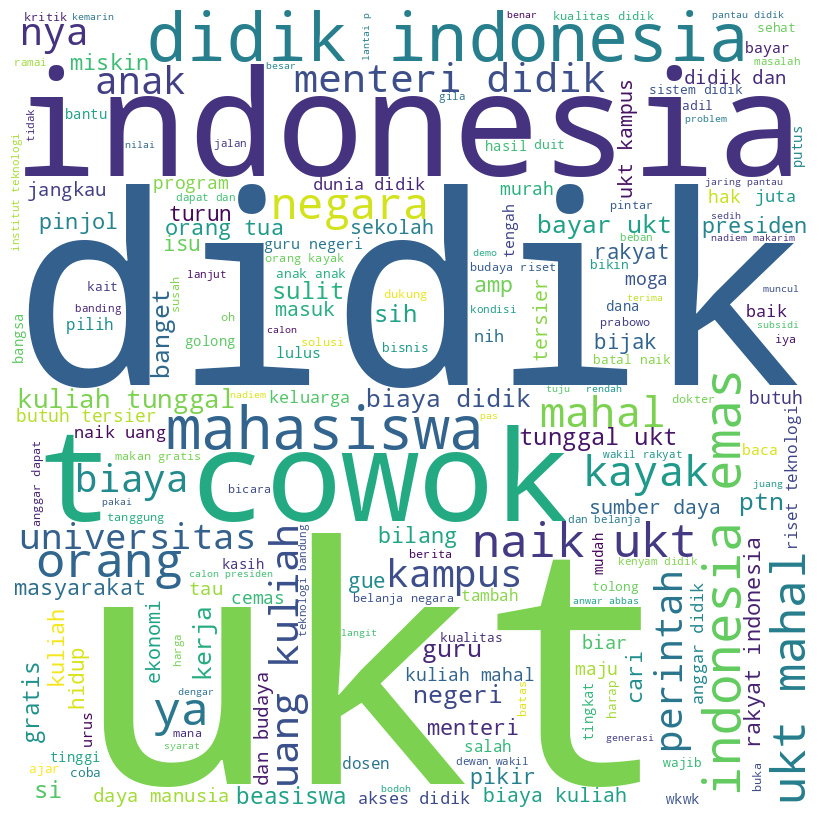

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Gabungkan semua teks dari kolom 'detokenize' menjadi satu string
all_text = ' '.join(df['detokenize'].astype(str).tolist())

# Buat objek WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(all_text)

# Tampilkan wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**Analisis WordCloud**



1.   **Kata Kunci Dominan**

Menurut pengamatan saya, Kata "didik," "indonesia," dan "ukt" (Uang Kuliah Tunggal) tampak sangat dominan. Hal ini menunjukkan bahwa topik pendidikan di Indonesia sering kali dikaitkan dengan sistem pembiayaan pendidikan, terutama terkait biaya kuliah. Kata "mahasiswa," "kuliah," dan "universitas" juga muncul, memperlihatkan bahwa perhatian utama dalam pendidikan adalah pada jenjang perguruan tinggi.

2.   **Isu Ekonomi**

Kata-kata seperti "uang," "mahal," "bayar," "gratis," dan "biaya" mengindikasikan bahwa ada kekhawatiran atau perdebatan tentang biaya pendidikan. "Naik" dan "turun" mungkin merujuk pada fluktuasi atau harapan mengenai perubahan biaya pendidikan. Isu UKT menjadi sorotan utama, mungkin karena adanya kebijakan atau perubahan yang berdampak pada biaya kuliah yang harus ditanggung oleh mahasiswa dan keluarganya.

3. **Ketimpangan Sosial dan Akses Pendidikan**

Kata "miskin," "hak," "tanggung," dan "gratis" mungkin menunjukkan adanya masalah ketimpangan akses pendidikan, di mana kelompok tertentu merasa sulit mengakses pendidikan berkualitas. Hal ini juga diperkuat dengan adanya kata "negara" dan "masyarakat," yang mengisyaratkan bahwa pendidikan menjadi isu sosial dan menjadi tanggung jawab bersama, termasuk peran pemerintah dalam menjamin akses yang setara.

4. **Peran Pemerintah dan Kebijakan**

Kata "menteri," "presiden," dan "perintah" menunjukkan bahwa ada harapan atau kritik terhadap peran pemerintah dalam mengelola dan mengatur sektor pendidikan. Kata "subsidi" dan "bantuan" mungkin mengacu pada harapan adanya bantuan pemerintah dalam meringankan beban biaya pendidikan bagi masyarakat.

5. **Tantangan dan Harapan dalam Pendidikan**

Kata "sulit," "cemas," dan "mahal" mungkin mengindikasikan tantangan yang dirasakan oleh masyarakat dalam mencapai pendidikan tinggi. Di sisi lain, kata-kata seperti "emas," "tinggi," "negeri," dan "maju" menunjukkan harapan bahwa pendidikan dapat menjadi jalan menuju masa depan yang lebih baik dan lebih berkualitas.

**Kesimpulan**


Secara keseluruhan, wordcloud ini mencerminkan bahwa topik pendidikan di Indonesia saat ini tidak hanya membahas akses dan kualitas, tetapi juga kuat dipengaruhi oleh isu ekonomi, peran pemerintah, serta ketimpangan sosial. Hal ini menunjukkan adanya kekhawatiran masyarakat terhadap aksesibilitas pendidikan tinggi, terutama mengenai pembiayaan yang sering kali menjadi beban bagi keluarga di Indonesia.
